<a href="https://colab.research.google.com/github/wenovus/ndt7-throughput-predict/blob/main/With_ElapsedTime_Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NDT Internet Speed Prediction using Deep Learning

**Author:** Wen Bo Li and Patricia Wei

**Date:** May 19, 2023


# Set up authentication

Run `gcloud auth application-default login --no-browser` and follow the instructions.

https://pandas-gbq.readthedocs.io/en/latest/howto/authentication.html#authenticating-with-a-user-account

# Getting the Raw Data

## Imports/utilities for Queries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import stats
import re
import statistics

import seaborn as sns
import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import figure

from datetime import datetime
from datetime import date
from datetime import timedelta
from dateutil.parser import parse as dateparser
import pytz
from pytz import timezone

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

utc_tz = pytz.timezone('UTC')

print("Hello, world!")

Hello, world!


## Helpers

In [2]:
def get_dists(df, col):
  # Frequency
  stats_df = df \
  .groupby(col) \
  [col] \
  .agg('count') \
  .pipe(pd.DataFrame) \
  .rename(columns = {col: 'frequency'})

  # PDF
  stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

  # CDF
  stats_df['cdf'] = stats_df['pdf'].cumsum()
  stats_df = stats_df.reset_index()
  return stats_df

## Query Parameters


In [3]:
start_date = '2023-02-01'
end_date = '2023-02-03'

start_time = f'{start_date} 00:00:00 UTC'
end_time = f'{end_date} 0:04:59 UTC'
start_time_dt = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S UTC')
end_time_dt = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S UTC')

num_days = 1
min_datapoints = 1
min_daily_datapoints = 1
min_duration = 1 #seconds

mlab_project = 'measurement-lab'

## Very Small Query Parameters so the query actually finishes

In [4]:
start_date = '2023-02-01'
end_date = '2023-02-01'

start_time = f'{start_date} 00:00:00 UTC'
end_time = f'{end_date} 2:59:59 UTC'
start_time_dt = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S UTC')
end_time_dt = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S UTC')

num_days = 1
min_datapoints = 1
min_daily_datapoints = 1
min_duration = 1 #seconds

mlab_project = 'measurement-lab'

## Query

### Subqueries

In [5]:
def get_bytes_sample(bytes_MB):
  return f'''
bytes_sample_{bytes_MB}MB AS (
  SELECT
    UUID,
    ARRAY (
      SELECT
        AS STRUCT *
      FROM
        UNNEST(Snapshots)
      WHERE
        BytesAcked < {bytes_MB*1e6}
      ORDER BY
        BytesAcked DESC
    ) AS Snapshots_sample
  FROM
    preprocessed
),
bytes_cum_sample_{bytes_MB}MB AS (
  SELECT
    UUID,
  IF
    (ARRAY_LENGTH(Snapshots_sample) > 0,
        Snapshots_sample[OFFSET(0)].CumAvgMbps, -1) AS Cum_Estimates_{bytes_MB}MB
  FROM
    bytes_sample_{bytes_MB}MB
),
bytes_p5_sample_{bytes_MB}MB AS (
  WITH
    tmp AS (
      SELECT
        UUID,
        APPROX_QUANTILES(CurrAvgMbps, 100)[OFFSET(5)] AS p5
      FROM
        bytes_sample_{bytes_MB}MB, UNNEST(Snapshots_sample)
      GROUP BY
        UUID
    )
  SELECT
    bytes_sample_{bytes_MB}MB.UUID,
    AVG(CurrAvgMbps) AS Sampled_Estimates_{bytes_MB}MB
  FROM
    bytes_sample_{bytes_MB}MB, UNNEST(Snapshots_sample)
  JOIN
    tmp
  ON
    tmp.UUID = bytes_sample_{bytes_MB}MB.UUID
  WHERE
    CurrAvgMbps > p5
  GROUP BY
    1
)
'''

def bytes_inner_join(bytes_MB):
  return f'''
INNER JOIN bytes_cum_sample_{bytes_MB}MB
ON bytes_cum_sample_{bytes_MB}MB.UUID = preprocessed.UUID
INNER JOIN bytes_p5_sample_{bytes_MB}MB
ON bytes_p5_sample_{bytes_MB}MB.UUID = preprocessed.UUID
'''

### Simplified Query

In [6]:
def get_data_v3(start_date, end_date, start_time, end_time, min_daily_datapoints, num_days, min_datapoints, min_duration, to_print=False):
  query = f'''
WITH
preprocessed AS (
  SELECT
    ndt7.raw.Download.UUID AS UUID,
    ndt7.raw.ClientIP AS ClientIP,
    ndt7.Server.Site AS Site,
    ndt7.a.TestTime AS TestTime,
    ndt7.a.MeanThroughputMbps AS ReturnedThroughputMbps,
    TIMESTAMP_DIFF(ndt7.raw.Download.EndTime, ndt7.raw.Download.StartTime, SECOND) AS Duration_s,
    (SELECT max(ServerMeasurements.TCPInfo.BytesAcked)
      FROM UNNEST(tcpinfo.raw.Snapshots) AS ServerMeasurements
    ) AS TotalBytesAcked,
    ARRAY (
      (
        SELECT AS STRUCT
          ROW_NUMBER() OVER snaps AS row_num,
          TIMESTAMP_DIFF(SM.Timestamp, SM.FirstTimestamp, MICROSECOND) as ElapsedTime_us,
          BytesAcked,
          IFNULL(TIMESTAMP_DIFF(SM.Timestamp, LAG(SM.Timestamp, 1) OVER snaps, MICROSECOND), 0) AS DeltaTime_us,
          IFNULL(BytesAcked - LAG(SM.BytesAcked, 1) OVER snaps, 0) AS DeltaBytes,
          IFNULL(SAFE_DIVIDE(((BytesAcked - LAG(SM.BytesAcked, 1) OVER snaps)/1e6)*8 , TIMESTAMP_DIFF(SM.Timestamp, LAG(SM.Timestamp, 1) OVER snaps, MICROSECOND)/1e6), 0) AS CurrAvgMbps,
          IFNULL(SAFE_DIVIDE((BytesAcked/1e6)*8, TIMESTAMP_DIFF(SM.Timestamp, FirstTimestamp, MICROSECOND)/1e6), 0) AS CumAvgMbps
        FROM (
          SELECT *
          FROM
            (
              (
                SELECT
                  ServerMeasurements.TCPInfo.BytesAcked,
                  ServerMeasurements.Timestamp
                  FROM
                    UNNEST(tcpinfo.raw.Snapshots) AS ServerMeasurements
              )
                CROSS JOIN
              (
                SELECT
                  MIN(ServerMeasurements.Timestamp) AS FirstTimestamp FROM
                  UNNEST(tcpinfo.raw.Snapshots) AS ServerMeasurements
              )
            )
        ) AS SM
        WINDOW
          snaps AS (ORDER BY SM.Timestamp)
      )
    ) AS Snapshots
FROM
  `measurement-lab.ndt.tcpinfo` AS tcpinfo
INNER JOIN
  `measurement-lab.ndt.ndt7` AS ndt7
ON ndt7.raw.Download.UUID = tcpinfo.raw.MetaData.UUID
INNER JOIN
  `measurement-lab.ndt.unified_downloads` AS unified_downloads
ON unified_downloads.a.UUID = tcpinfo.raw.MetaData.UUID
  WHERE
    (ndt7.date BETWEEN '{start_date}' AND '{end_date}')
    AND (tcpinfo.date BETWEEN '{start_date}' AND '{end_date}')
    AND (unified_downloads.date BETWEEN '{start_date}' AND '{end_date}')
    AND ndt7.a.TestTime >= TIMESTAMP('{start_time}')
    AND ndt7.a.TestTime <= TIMESTAMP('{end_time}')
)

SELECT
  preprocessed.UUID,
  preprocessed.ClientIP,
  Site,
  TestTime,
  TotalBytesAcked,
  Duration_s,
  ReturnedThroughputMbps,
  Snapshots
FROM
  preprocessed
WHERE
  ARRAY_LENGTH(preprocessed.Snapshots) > 0
  AND Duration_s > {min_duration}
'''

  if to_print:
    print(query)
  return pd.read_gbq(query, project_id=mlab_project)

### Make the Query

In [7]:
df_v3 = get_data_v3(start_date, end_date, start_time, end_time, min_daily_datapoints, num_days, min_datapoints, min_duration, to_print=False)

In [8]:
df_v3['Cum_Estimate_full'] = (df_v3.TotalBytesAcked/df_v3.Duration_s)/1e6

## Total tests
print(f"{len(df_v3)} tests")
print(f"{len(df_v3.ClientIP.unique())} client IPs")

379569 tests
206641 client IPs


## Bytes per test (sanity check of data)

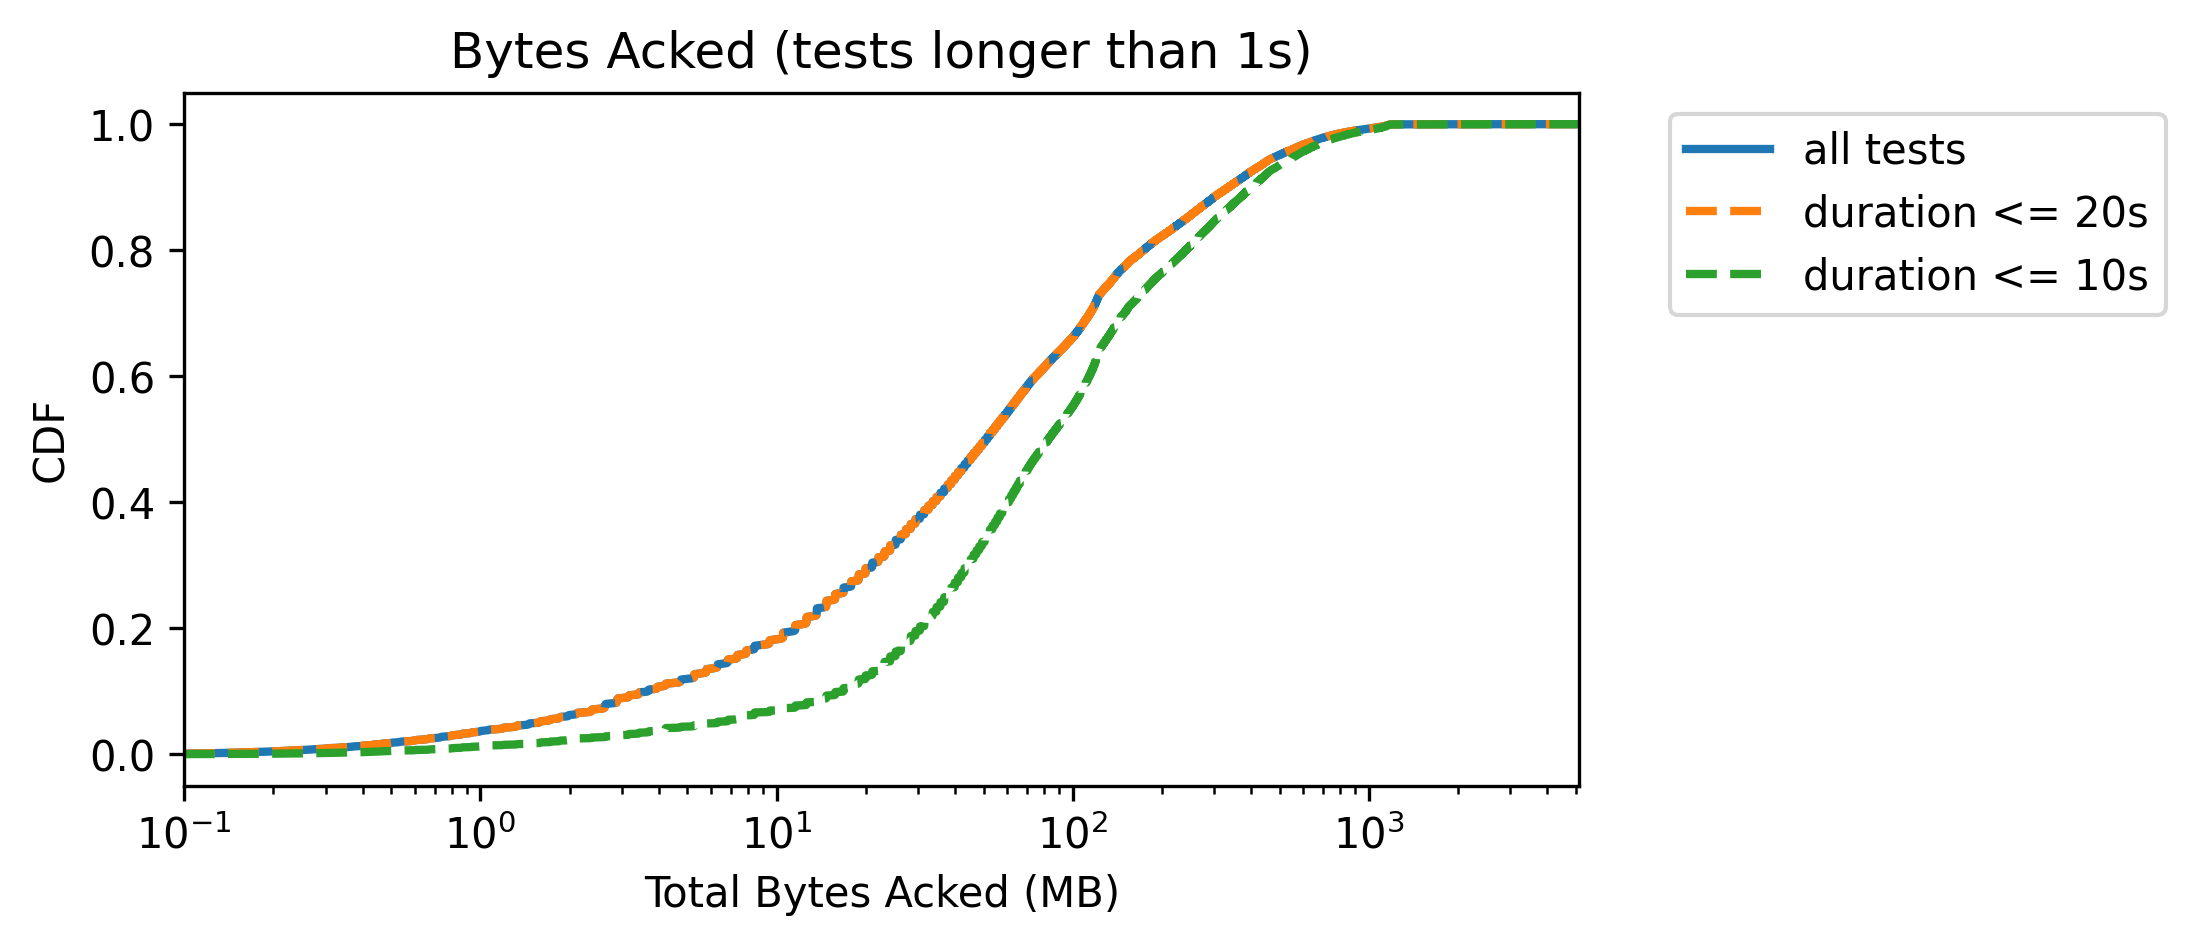

In [9]:
data_dist = get_dists(df_v3, 'TotalBytesAcked')
data_dist_lt20s = get_dists(df_v3[df_v3.Duration_s <= 20], 'TotalBytesAcked')
data_dist_lt10s = get_dists(df_v3[df_v3.Duration_s <= 10], 'TotalBytesAcked')

fig, ax = plt.subplots(dpi=300, figsize=(6,3))
ax.plot(data_dist.TotalBytesAcked/1e6, data_dist.cdf, linewidth=2, label='all tests')
ax.plot(data_dist_lt20s.TotalBytesAcked/1e6, data_dist_lt20s.cdf, linewidth=2, linestyle='--', label='duration <= 20s')
ax.plot(data_dist_lt10s.TotalBytesAcked/1e6, data_dist_lt10s.cdf, linewidth=2, linestyle='--', label='duration <= 10s')

ax.set_xscale('log')
ax.set_xlim(0.1, max(df_v3.TotalBytesAcked)/1e6)
ax.set_xlabel('Total Bytes Acked (MB)')
ax.set_ylabel("CDF")
ax.set_title(f"Bytes Acked (tests longer than {min_duration}s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

print()

In [10]:
print(f"Most bytes transferred {max(df_v3.TotalBytesAcked)/1e6}MB")

Most bytes transferred 5127.710789MB


## Time series of a single test

In [11]:
print(df_v3.keys())
dp = df_v3
print("dp.TotalBytesAcked", dp.TotalBytesAcked[0])
print("dp.Duration_s", dp.Snapshots[0][-1]["ElapsedTime_us"], dp.Snapshots[1][-1]["ElapsedTime_us"])
print("# of snapshots", len(dp.Snapshots[0]), len(dp.Snapshots[1]))
print("avg throughput:", dp.TotalBytesAcked[0] * 8 / dp.Duration_s[0] / 1e6)
print("returned mean throughput:", dp.ReturnedThroughputMbps[0])
dp["Snapshots"][8]
#dp["Snapshots"][1][:10]

# Observations
# 1. Delta between timestamps are not uniform and not predictable.
# 2. Total test time is not constant.
# 3. Total number of snapshots is not constant.
# 4. "ReturnedThroughputMbps" does NOT match a naive (Bytes/ElapsedTime) computation.
#   4a. Question: is ReturnedThroughputMbps the ground truth?

Index(['UUID', 'ClientIP', 'Site', 'TestTime', 'TotalBytesAcked', 'Duration_s',
       'ReturnedThroughputMbps', 'Snapshots', 'Cum_Estimate_full'],
      dtype='object')
dp.TotalBytesAcked 13343073
dp.Duration_s 19169955 37010226
# of snapshots 22 189
avg throughput: 7.1163056
returned mean throughput: 21.834111387767198


array([{'row_num': 1, 'ElapsedTime_us': 0, 'BytesAcked': 0, 'DeltaTime_us': 0, 'DeltaBytes': 0, 'CurrAvgMbps': 0.0, 'CumAvgMbps': 0.0},
       {'row_num': 2, 'ElapsedTime_us': 521961, 'BytesAcked': 16137, 'DeltaTime_us': 521961, 'DeltaBytes': 16137, 'CurrAvgMbps': 0.24732882341784154, 'CumAvgMbps': 0.24732882341784154},
       {'row_num': 3, 'ElapsedTime_us': 669960, 'BytesAcked': 30657, 'DeltaTime_us': 147999, 'DeltaBytes': 14520, 'CurrAvgMbps': 0.784870168041676, 'CumAvgMbps': 0.3660755866021852},
       {'row_num': 4, 'ElapsedTime_us': 769973, 'BytesAcked': 45177, 'DeltaTime_us': 100013, 'DeltaBytes': 14520, 'CurrAvgMbps': 1.1614490116284881, 'CumAvgMbps': 0.4693878876272285},
       {'row_num': 5, 'ElapsedTime_us': 889967, 'BytesAcked': 49533, 'DeltaTime_us': 119994, 'DeltaBytes': 4356, 'CurrAvgMbps': 0.2904145207260363, 'CumAvgMbps': 0.4452569589658943},
       {'row_num': 6, 'ElapsedTime_us': 999972, 'BytesAcked': 71313, 'DeltaTime_us': 110005, 'DeltaBytes': 21780, 'CurrAvgMbps':

### Plots of Multiple tests

In [12]:
def plot_snapshots(snapshots, returnedthroughputs, rows, cols, truncate=0, predictedthroughputs=[], predictedvars=[], **kwargs):
  plotX = rows
  plotY = cols

  figure(figsize=(plotY * 2, plotX * 2))

  def plot_snapshot(i, timestamps, series, baseline, ground_truth):
      plt.subplot(plotX, plotY, i+1)
      plt.plot(timestamps, series)
      plt.axhline(baseline, color='c')
      plt.axhline(ground_truth, color='r')

  # i: Current plot index
  # index: Current data index
  i, index = 0, -1
  while i != plotX * plotY:
    index += 1
    data = snapshots[index]
    series = []
    timestamps = []
    baseline_series = []
    for k, snapshot in enumerate(data):
      if truncate > 0 and k == truncate:
        break
      timestamps.append(snapshot["ElapsedTime_us"] / 1e6)
      series.append(snapshot["CurrAvgMbps"])

    baseline = sum(series) / len(series) if truncate <= 0 else sum(series[:truncate]) / truncate
    ground_truth = returnedthroughputs[index]
    if len(predictedthroughputs) > 0:
      pred_value = predictedthroughputs[index]
      if "error_threshold" in kwargs:
        error = abs(pred_value - ground_truth) / ground_truth
        if error < kwargs["error_threshold"]:
          continue
        error_sep = ", "
        if i % plotX == 0:
          print("\nerrors: ", end="")
          error_sep = "\n"
        print(round(error, 4), end=error_sep)
      plot_snapshot(i, timestamps, series, baseline, ground_truth)
      i += 1
      if len(predictedvars) > 0:
        # Plot variance
        plt.axhline(pred_value-predictedvars[index], color='g')
        plt.axhline(pred_value+predictedvars[index], color='g')
      else:
        plt.axhline(pred_value, color='g')
    else:
      plot_snapshot(i, timestamps, series, baseline, ground_truth)
      i += 1

Index(['UUID', 'ClientIP', 'Site', 'TestTime', 'TotalBytesAcked', 'Duration_s',
       'ReturnedThroughputMbps', 'Snapshots', 'Cum_Estimate_full'],
      dtype='object')


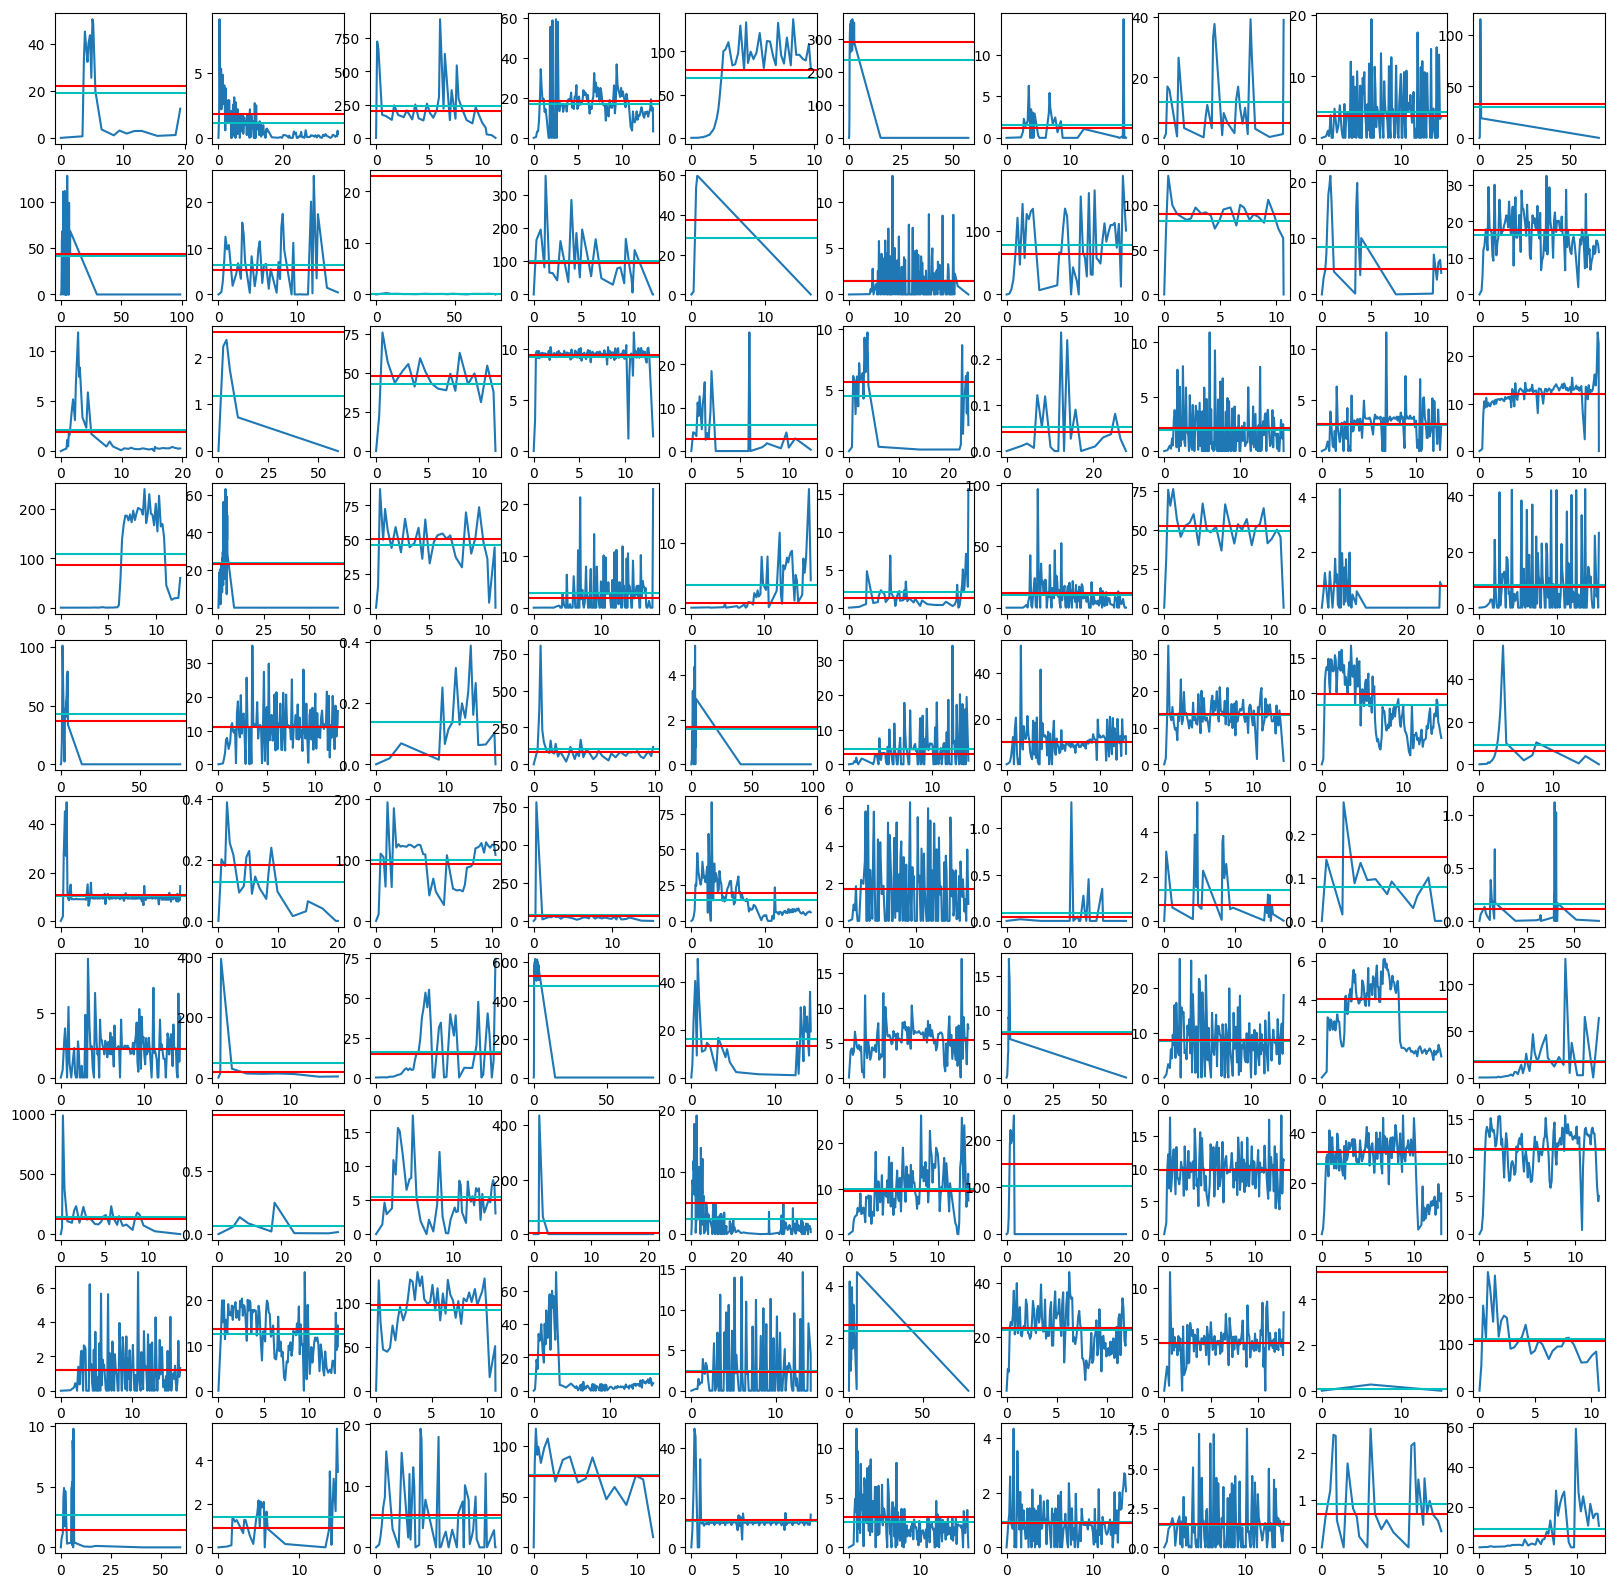

In [13]:
print(df_v3.keys())
plot_snapshots(df_v3.Snapshots, df_v3.ReturnedThroughputMbps, 10, 10)

# First model -- baseline

The first model will be just use the first INPUT_TRUNCATE_SNAPSHOTS datapoints. If there are less than MINIMUM_SNAPSHOTS datapoints in total then the test will not be used.

## Imports/Utilities for Tensorflow

In [14]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

tf.__version__

2023-08-12 16:37:46.556694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 16:37:47.473178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.13.0'

## Utilities for Creating training/dev/test

### Visualizing how many snaphots each test has

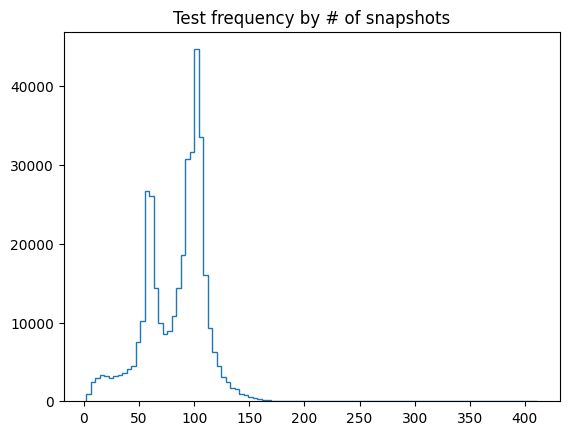

In [15]:
frequencies = []
for snapshots in df_v3.Snapshots:
  frequencies.append(len(snapshots))

counts, bins = np.histogram(frequencies, bins=100)
plt.title("Test frequency by # of snapshots")
plt.stairs(counts, bins)

#### get_valid_serieses

In [16]:
# INPUT_TRUNCATE_SNAPSHOTS is the number of snapshots with which we will predict
# the final bandwidth.
#########INPUT_TRUNCATE_SNAPSHOTS = 80
# MINIMUM_SNAPSHOTS is an important number: it filters the dataset such that
# only the tests with at least this many number of datapoints is given a
# prediction.
#
# We can tweak this number such that only, say, tests with 50, or 70 datapoints
# are retained as "good tests". In order to do that though we would need a good
# rationale.
#########MINIMUM_SNAPSHOTS = 80

MAX_SNAPSHOTS = 90
truncateNs = list(range(30, MAX_SNAPSHOTS + 1, 10))

# get_valid_serieses returns all tests that contains the minimum number of snapshots
def get_valid_serieses(minSnapshotsN):
  valid_serieses = []
  valid_returnedthroughputs = []
  for i in range(len(df_v3.Snapshots)):
    if len(df_v3.Snapshots[i]) >= MAX_SNAPSHOTS:
      valid_serieses.append(df_v3.Snapshots[i])
      valid_returnedthroughputs.append(df_v3.ReturnedThroughputMbps[i])
  return valid_serieses, valid_returnedthroughputs

### Visualizing tests with `MINIMUM_SNAPSHOTS`



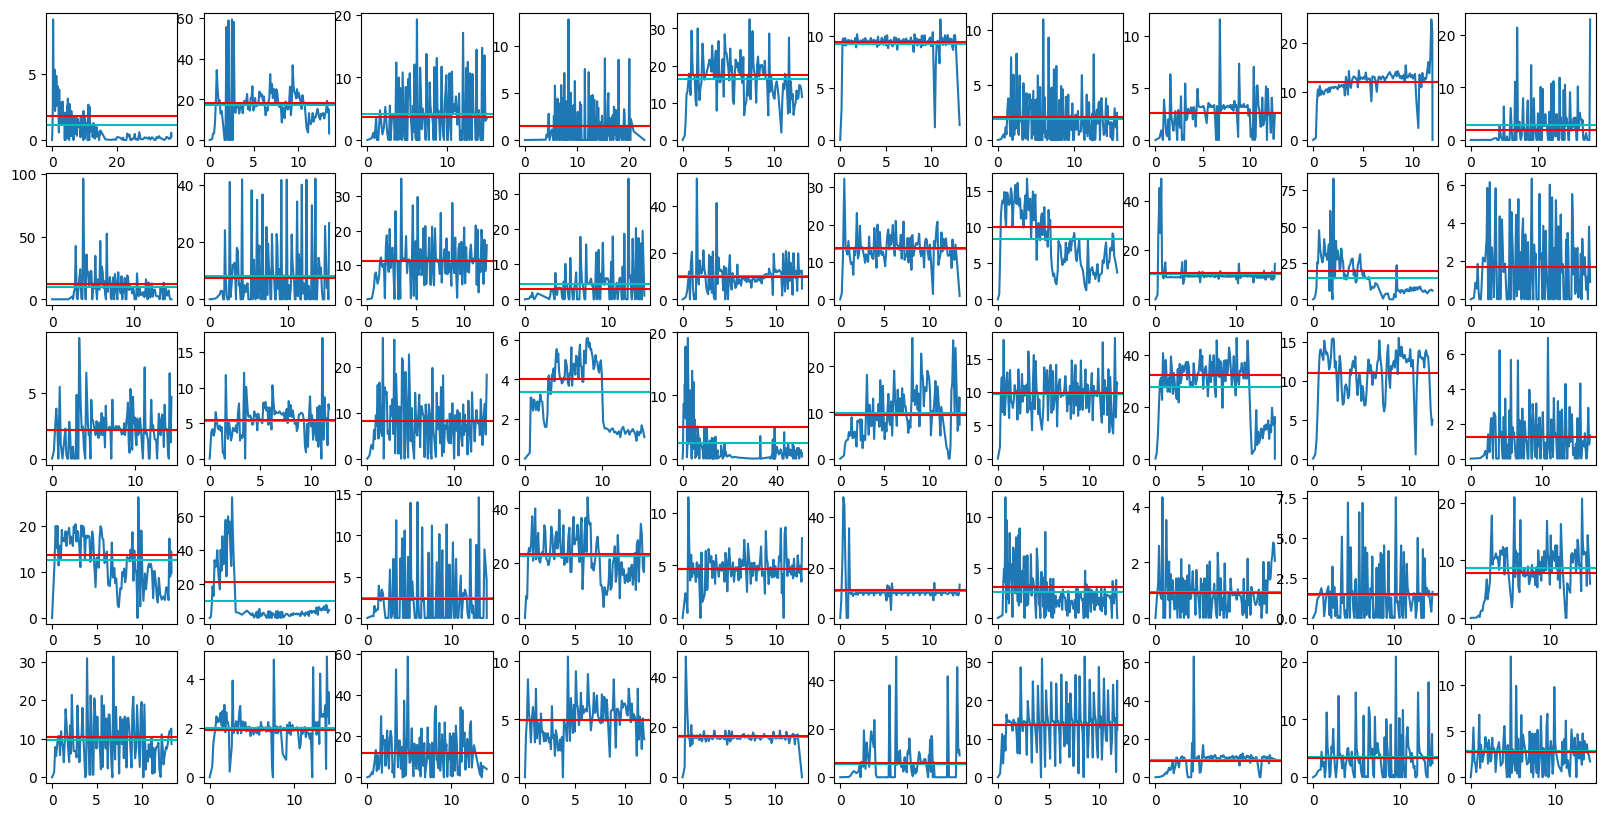

In [17]:
# Whether to enable printing the visualizations
# NOTE: There is a separate flag for the later result visualizations for convenience.
plot_visualization = True

if plot_visualization:
  SNAPSHOT_TRUNC_FOR_VISUALIZATION = truncateNs[-1]
  valid_serieses, valid_returnedthroughputs = get_valid_serieses(SNAPSHOT_TRUNC_FOR_VISUALIZATION)
  plot_snapshots(valid_serieses, valid_returnedthroughputs, 5, 10)

### Visualizing tests with `MINIMUM_SNAPSHOTS` and truncated with `INPUT_TRUNCATE_SNAPSHOTS`


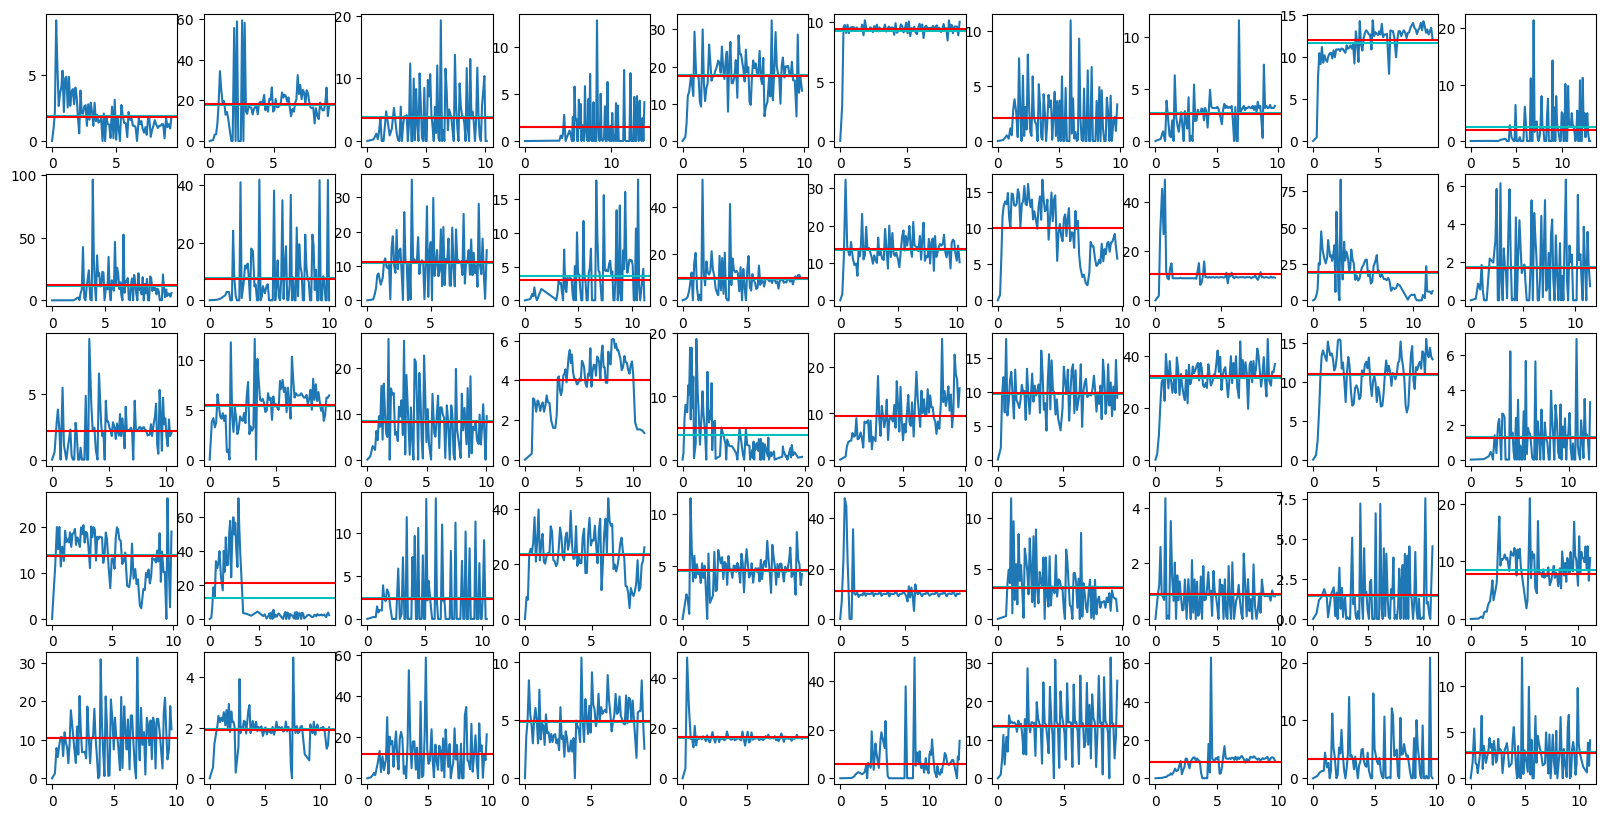

In [18]:
if plot_visualization:
  plot_snapshots(valid_serieses, valid_returnedthroughputs, 5, 10, truncate=SNAPSHOT_TRUNC_FOR_VISUALIZATION)

### Truncate and Create training/dev/test

In [44]:
### Normalization idea: normalize everything to have the same range, but don't
### touch standard deviation or the mean (other than the range lower the mean
### proportionally).
def normalize(x, y):
  maxes = x.max(axis=1, keepdims=True)
  x /= maxes
  maxes = maxes.squeeze()
  y /= maxes

  def denormalize(y_norm):
    return y_norm * maxes
  return x, y, denormalize

def split_datasets_feature(valid_serieses, truncateN, feature_name):
  onedim_valid_serieses = []
  for series in valid_serieses:
    onedim_series = []
    for snapshot in series[:truncateN]:
      onedim_series.append(snapshot[feature_name])
    onedim_valid_serieses.append(onedim_series)

  onedim_valid_serieses = np.asarray(onedim_valid_serieses)

  TrainingSetEndIndex = round(len(onedim_valid_serieses) * 0.8)
  DevSetEndIndex = round(TrainingSetEndIndex + len(onedim_valid_serieses) * 0.1)
  TestSetEndIndex = len(onedim_valid_serieses)

  training_set = onedim_valid_serieses[:TrainingSetEndIndex]
  dev_set = onedim_valid_serieses[TrainingSetEndIndex:DevSetEndIndex]
  test_set = onedim_valid_serieses[DevSetEndIndex:]

  return training_set, dev_set, test_set

def split_datasets(valid_serieses, valid_returnedthroughputs, truncateN, debug=False):
  onedim_valid_serieses = []
  labels = valid_returnedthroughputs
  for series in valid_serieses:
    onedim_series = []
    for snapshot in series[:truncateN]:
      onedim_series.append(snapshot["CurrAvgMbps"])
    onedim_valid_serieses.append(onedim_series)

  onedim_valid_serieses = np.asarray(onedim_valid_serieses)
  labels = np.asarray(labels).T

  TrainingSetEndIndex = round(len(onedim_valid_serieses) * 0.8)
  DevSetEndIndex = round(TrainingSetEndIndex + len(onedim_valid_serieses) * 0.1)
  TestSetEndIndex = len(onedim_valid_serieses)

  training_set = onedim_valid_serieses[:TrainingSetEndIndex]
  training_set_labels = labels[:TrainingSetEndIndex]
  dev_set = onedim_valid_serieses[TrainingSetEndIndex:DevSetEndIndex]
  dev_set_labels = labels[TrainingSetEndIndex:DevSetEndIndex]
  test_set = onedim_valid_serieses[DevSetEndIndex:]
  test_set_labels = labels[DevSetEndIndex:]

  training_set_unnorm, training_set_labels_unnorm = training_set.copy(), training_set_labels.copy()
  dev_set_unnorm, dev_set_labels_unnorm = dev_set.copy(), dev_set_labels.copy()
  test_set_unnorm, test_set_labels_unnorm = test_set.copy(), test_set_labels.copy()

  training_set, training_set_labels, denormalize_training = normalize(training_set, training_set_labels)
  dev_set, dev_set_labels, denormalize_dev = normalize(dev_set, dev_set_labels)
  test_set, test_set_labels, denormalize_test = normalize(test_set, test_set_labels)

  fx_train, fx_dev, fx_test = split_datasets_feature(valid_serieses, truncateN, "ElapsedTime_us")
  print(training_set[0], type(training_set[0]), type(fx_train[0]), training_set[0].shape, fx_train[0].shape)
  new_training_set, new_dev_set, new_test_set = [], [], []
  for i, s in enumerate(training_set):
    new_training_set.append(np.concatenate((s, fx_train[i] / fx_train[i][-1])))
  for i, s in enumerate(dev_set):
    new_dev_set.append(np.concatenate((s, fx_dev[i] / fx_dev[i][-1])))
  for i, s in enumerate(test_set):
    new_test_set.append(np.concatenate((s, fx_test[i] / fx_test[i][-1])))
  training_set = np.asarray(new_training_set)
  dev_set = np.asarray(new_dev_set)
  test_set = np.asarray(new_test_set)
  print(training_set[0])

  return training_set, training_set_labels, denormalize_training, training_set_labels_unnorm, dev_set, dev_set_labels, denormalize_dev, dev_set_labels_unnorm, test_set, test_set_labels, denormalize_test, test_set_labels_unnorm


## Multi-level Perceptron Model (initial model)

#### Get Data Function

In [45]:
# These maps are for visualization
valid_serieses_map, valid_returnedthroughputs_map = {}, {}

def get_input(minSnapshotN, truncateN, debug=False):
  valid_serieses, valid_returnedthroughputs = get_valid_serieses(minSnapshotN)
  valid_serieses_map[minSnapshotN], valid_returnedthroughputs_map[minSnapshotN] = valid_serieses, valid_returnedthroughputs
  training_set, training_set_labels, denormalize_training, training_set_labels_unnorm, dev_set, dev_set_labels, denormalize_dev, dev_set_labels_unnorm, test_set, test_set_labels, denormalize_test, test_set_labels_unnorm = split_datasets(valid_serieses, valid_returnedthroughputs, truncateN, debug=debug)
  x_train, y_train, x_dev, y_dev, x_test, y_test = training_set, training_set_labels, dev_set, dev_set_labels, test_set, test_set_labels
  #fx_train, fx_dev, fx_test = split_datasets_feature(valid_serieses, truncateN, "ElapsedTime_us")
  return (
      [x_train, y_train, x_dev, y_dev, x_test, y_test],
      [denormalize_training, denormalize_dev, denormalize_test],
      [training_set_labels_unnorm, dev_set_labels_unnorm, test_set_labels_unnorm]
  )


#### Model

In [46]:
learning_rate = 1e-3
num_epochs = 10
minibatch_size = 1000

enable_JTT = False
JTT_upsample = 10
JTT_cutoff_diff = 0.20

TWO_STAGE_learning_rate = 1e-3
TWO_STAGE_ERR_CUTOFF = 0.05

# Note: this is not a hyperparameter, this is the plotting density. The lower
# the number the more computation it has to run and hence the slower the training.
epoch_spacing = 20

def jtt_reweigh_fn(ratio_diffs):
    return 1 + 1000 * ratio_diffs

def custom_loss(y_true, y_pred):
  loss = tf.reduce_mean(tf.pow(tf.abs(y_true - y_pred), 1.5))
  return loss

loss = tf.keras.losses.MeanSquaredError()
#loss = tf.keras.losses.MeanAbsoluteError()
metrics = [tf.keras.losses.MeanSquaredError()]
#loss = custom_loss

W, b, costs, train_acc, test_acc, train_preds, test_preds, training_set_labels_unnorm, dev_set_labels_unnorm, test_set_labels_unnorm = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

history = {}

denormalize_training, denormalize_dev, denormalize_test = {}, {}, {}

models = {}
history_stop = {}
train_stop_preds, test_stop_preds = {}, {}

for truncateN in truncateNs:
  # Use equal weighting at first.
  sample_weights = None
  for trainCount in range(1, 3): # Just train twice!
    if not enable_JTT and trainCount == 2:
      continue
    print(f"truncateN: {truncateN}")
    data_np, denorm_funcs, unnorm_labels = get_input(truncateN, truncateN, debug=False)

    x_train_np, y_train_np, x_dev_np, y_dev_np, x_test_np, y_test_np = data_np
    denormalize_training[truncateN], denormalize_dev[truncateN], denormalize_test[truncateN] = denorm_funcs
    training_set_labels_unnorm[truncateN], dev_set_labels_unnorm[truncateN], test_set_labels_unnorm[truncateN] = unnorm_labels
    #fx_train, fx_dev, fx_test = other_features

    model = tf.keras.models.Sequential(
        [tf.keras.layers.Input(shape=(len(x_train_np[0]),))]
        + [ tf.keras.layers.Dense(dim, activation=tf.nn.leaky_relu) for dim in [64, 16, 1] ]
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss,
                  metrics=metrics)

    print(f"{x_train_np.shape}, {y_train_np.shape}")
    history[truncateN] = model.fit(
        x_train_np,
        y_train_np,
        validation_data=(x_test_np, y_test_np),
        sample_weight=sample_weights,
        epochs=num_epochs,
        verbose=1,
    )
    train_preds[truncateN] = model.predict(x_train_np).squeeze()
    test_preds[truncateN] = model.predict(x_test_np).squeeze()

    # Store the models
    models[truncateN] = model

    if enable_JTT and trainCount == 1: # Reallocate weights
      diffs = np.abs(train_preds[truncateN] - y_train_np) / y_train_np
      #new_weights = np.floor(diffs + 1 - JTT_cutoff_diff) * JTT_upsample
      #new_weights += 1
      #sample_weights = new_weights
      sample_weights = jtt_reweigh_fn(diffs)
      print("first ten JTT sample weights: ", sample_weights[:10])


    ###### TWO-STAGE PREDICTION ######
    diffs = np.abs(train_preds[truncateN] - y_train_np) / y_train_np
    y_stop_train = (diffs <= TWO_STAGE_ERR_CUTOFF).astype(int)
    diffs = np.abs(test_preds[truncateN] - y_test_np) / y_test_np
    y_stop_test = (diffs <= TWO_STAGE_ERR_CUTOFF).astype(int)

    stop_model = tf.keras.models.Sequential(
        [tf.keras.layers.Input(shape=(len(x_train_np[0]),))]
        + [ tf.keras.layers.Dense(dim, activation=tf.nn.leaky_relu) for dim in [64, 16] ]
        + [ tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) ]
    )

    stop_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TWO_STAGE_learning_rate),
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=["accuracy"])

    print(f"{x_train_np.shape}, {y_train_np.shape}")
    history_stop[truncateN] = stop_model.fit(
        x_train_np,
        y_stop_train,
        validation_data=(x_test_np, y_stop_test),
        sample_weight=sample_weights,
        epochs=num_epochs,
        verbose=1,
    )
    train_stop_preds[truncateN] = stop_model.predict(x_train_np).squeeze()
    test_stop_preds[truncateN] = stop_model.predict(x_test_np).squeeze()




truncateN: 30
[0.         0.10703979 0.24079524 1.         0.60768    0.28985536
 0.39220507 0.44334384 0.58249397 0.24039817 0.51930407 0.5322416
 0.27825288 0.5314649  0.29131983 0.40505924 0.43037114 0.3039403
 0.4430424  0.36715836 0.18986772 0.06327849 0.41795136 0.22791875
 0.22790735 0.28826563 0.29716793 0.12528575 0.30398895 0.17708594] <class 'numpy.ndarray'> <class 'numpy.ndarray'> (30,) (30,)
[0.         0.10703979 0.24079524 1.         0.60768    0.28985536
 0.39220507 0.44334384 0.58249397 0.24039817 0.51930407 0.5322416
 0.27825288 0.5314649  0.29131983 0.40505924 0.43037114 0.3039403
 0.4430424  0.36715836 0.18986772 0.06327849 0.41795136 0.22791875
 0.22790735 0.28826563 0.29716793 0.12528575 0.30398895 0.17708594
 0.         0.04096798 0.07517754 0.10942819 0.14367405 0.17807642
 0.21234454 0.24657156 0.28080954 0.31507561 0.34930537 0.38351767
 0.41779641 0.45205871 0.48628813 0.52053913 0.55479046 0.58902502
 0.62327534 0.65751948 0.69177117 0.72602867 0.76026049 0.

In [47]:
model.evaluate(x_test_np, y_test_np, return_dict=True)["loss"]
model.metrics_names

622/622 [==============================] - 1s 1ms/step - loss: 3.8703e-04 - mean_squared_error: 3.8703e-04


['loss', 'mean_squared_error']

### Loss Plot per iteration

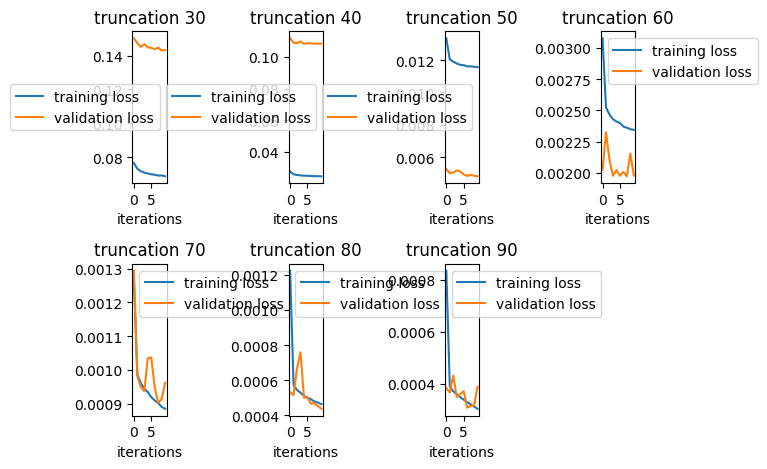

In [48]:
# Plot the train loss

#fig, ax = plt.subplots()
#fig.tight_layout(pad=50)
for i, truncateN in enumerate(truncateNs):
  plt.subplot(2, 4, i+1)
  plt.plot(np.squeeze(history[truncateN].history["loss"]), label="training loss")
  #plt.ylabel('Train Loss')
  plt.xlabel('iterations')
  plt.title(f"truncation {truncateN}")
  # Plot the test loss
  plt.subplot(2, 4, i+1)
  plt.plot(np.squeeze(history[truncateN].history["val_loss"]), label="validation loss")
  #plt.ylabel('Test Loss')
  plt.xlabel('iterations')
  plt.title(f"truncation {truncateN}")
  plt.legend()
plt.tight_layout()
plt.show()


### Debugging

In [49]:
print(test_preds[SNAPSHOT_TRUNC_FOR_VISUALIZATION].shape)

# DEBUG: This is to check that these two tensors are indeed the same.
#yl = list(y_train.as_numpy_iterator())
#print(yl == training_set_labels)

#print(yl == training_set_labels)

"""

print(training_set_labels_unnorm.shape, train_preds.shape)

def print_samples(n):
  for i in range(n):
    print(training_set_labels_unnorm[i])
    print(train_preds[i])
print("Training set samples")
print_samples(20)

"""

print(test_set_labels_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION][0])
print(test_preds[SNAPSHOT_TRUNC_FOR_VISUALIZATION][0])

(19904,)
19.89603717972115
0.301632


### Unnormalize predictions

In [50]:
train_preds_unnorm, test_preds_unnorm = {}, {}
train_preds_var_unnorm, test_preds_var_unnorm = {}, {}

for truncateN in truncateNs:
  train_preds_unnorm[truncateN] = denormalize_training[truncateN](train_preds[truncateN])
  test_preds_unnorm[truncateN] = denormalize_test[truncateN](test_preds[truncateN])
  train_preds_var_unnorm[truncateN] = []
  test_preds_var_unnorm[truncateN] = []

  # Shape check
  print(train_preds_unnorm[truncateN].shape)
  print(test_preds_unnorm[truncateN].shape)

(159232,)
(19904,)
(159232,)
(19904,)
(159232,)
(19904,)
(159232,)
(19904,)
(159232,)
(19904,)
(159232,)
(19904,)
(159232,)
(19904,)


### Finding the actual pred from both STOP and PRED models

In [51]:
def two_stage_preds(preds_unnorm, stop_preds):
  cum_mask = 0
  two_stage_preds = 0
  cutoffs = 0
  for truncateN in truncateNs:
    #print(train_preds[truncateN].shape)
    if truncateN == truncateNs[-1]:
      # If all other truncations were rejected, then use the prediction from the last.
      cur_mask = 1 - cum_mask
    else:
      cur_mask = np.maximum(0, ((stop_preds[truncateN] > 0.5) - cum_mask))
    cutoffs += truncateN * cur_mask
    two_stage_preds += preds_unnorm[truncateN] * cur_mask
    cum_mask += cur_mask

  two_stage_preds += preds_unnorm[truncateNs[-1]] * cur_mask
  print(cutoffs, np.average(cutoffs), np.min(cutoffs), np.max(cutoffs))

  return two_stage_preds, np.average(cutoffs)

train_preds_two_stage, train_pred_avg_cutoff = two_stage_preds(train_preds_unnorm, train_stop_preds)
test_preds_two_stage, test_pred_avg_cutoff = two_stage_preds(test_preds_unnorm, test_stop_preds)

[90 40 70 ... 60 80 40] 49.63405596864952 30 90
[60 60 60 ... 90 60 30] 49.97688906752411 30 90


## Result Visualization

### CDF of Accuracy

In [52]:
model_diffs, baseline_diffs, average_diffs = {}, {}, {}
averages = {}

def calculate_model_diffs(preds_unnorm, labels_unnorm):
  print(preds_unnorm)
  print(labels_unnorm)
  print(preds_unnorm.shape)
  print(labels_unnorm.shape)
  model_diffs = np.abs(labels_unnorm - preds_unnorm) / labels_unnorm
  return model_diffs

for truncateN in truncateNs:
  #print(test_preds_unnorm[truncateN])
  #print(test_set_labels_unnorm[truncateN])
  #print(test_preds_unnorm[truncateN].shape)
  #print(test_set_labels_unnorm[truncateN].shape)
  #model_diffs[truncateN] = np.abs(test_set_labels_unnorm[truncateN] - test_preds_unnorm[truncateN]) / test_set_labels_unnorm[truncateN]
  model_diffs[truncateN] = calculate_model_diffs(test_preds_unnorm[truncateN], test_set_labels_unnorm[truncateN])

  baseline = np.asarray(list(np.sum(snapshot["CurrAvgMbps"] for snapshot in series[:truncateN]) / truncateN for series in valid_serieses_map[truncateN][-len(test_preds_unnorm[truncateN]):]))
  baseline_diffs[truncateN] = np.abs(test_set_labels_unnorm[truncateN] - baseline) / test_set_labels_unnorm[truncateN]

  averages[truncateN] = (test_preds_unnorm[truncateN] + baseline) / 2
  average_diffs[truncateN] = np.abs(test_set_labels_unnorm[truncateN] - averages[truncateN]) / test_set_labels_unnorm[truncateN]

two_stage_model_diffs = calculate_model_diffs(test_preds_two_stage, test_set_labels_unnorm[truncateNs[-1]])
#two_stage_model_diffs = calculate_model_diffs(test_preds_unnorm[30], test_set_labels_unnorm[truncateNs[-1]])

[19.06327912 15.37163717 17.31606923 ...  1.45101766 11.79185818
 11.17144911]
[19.89603718 13.52306833 14.19232902 ...  2.10141909 11.67058163
 10.2720151 ]
(19904,)
(19904,)
[18.10238316 13.28655038 14.39449836 ...  1.5420786  11.25567788
 10.13441853]
[19.89603718 13.52306833 14.19232902 ...  2.10141909 11.67058163
 10.2720151 ]
(19904,)
(19904,)
[19.60924067 12.97065028 14.58409611 ...  2.10570628 12.04894276
  9.36752101]
[19.89603718 13.52306833 14.19232902 ...  2.10141909 11.67058163
 10.2720151 ]
(19904,)
(19904,)
[19.91229457 12.94699389 14.1497015  ...  2.02452124 11.33871216
  9.73725979]
[19.89603718 13.52306833 14.19232902 ...  2.10141909 11.67058163
 10.2720151 ]
(19904,)
(19904,)
[19.94879008 13.23968016 14.23914011 ...  2.38648945 11.45428382
 10.07069733]
[19.89603718 13.52306833 14.19232902 ...  2.10141909 11.67058163
 10.2720151 ]
(19904,)
(19904,)
[19.14673561 12.87406584 13.78535286 ...  2.04428741 11.16872378
 10.31508755]
[19.89603718 13.52306833 14.19232902 ... 

Average error for 30: 15.0
Average baseline error for 30: 15.7
Average error for 40: 10.1
Average baseline error for 40: 11.7
Average error for 50: 7.4
Average baseline error for 50: 8.9
Average error for 60: 6.0
Average baseline error for 60: 6.7
Average error for 70: 4.4
Average baseline error for 70: 5.1
Average error for 80: 3.4
Average baseline error for 80: 4.0
Average error for 90: 3.4
Average baseline error for 90: 3.5


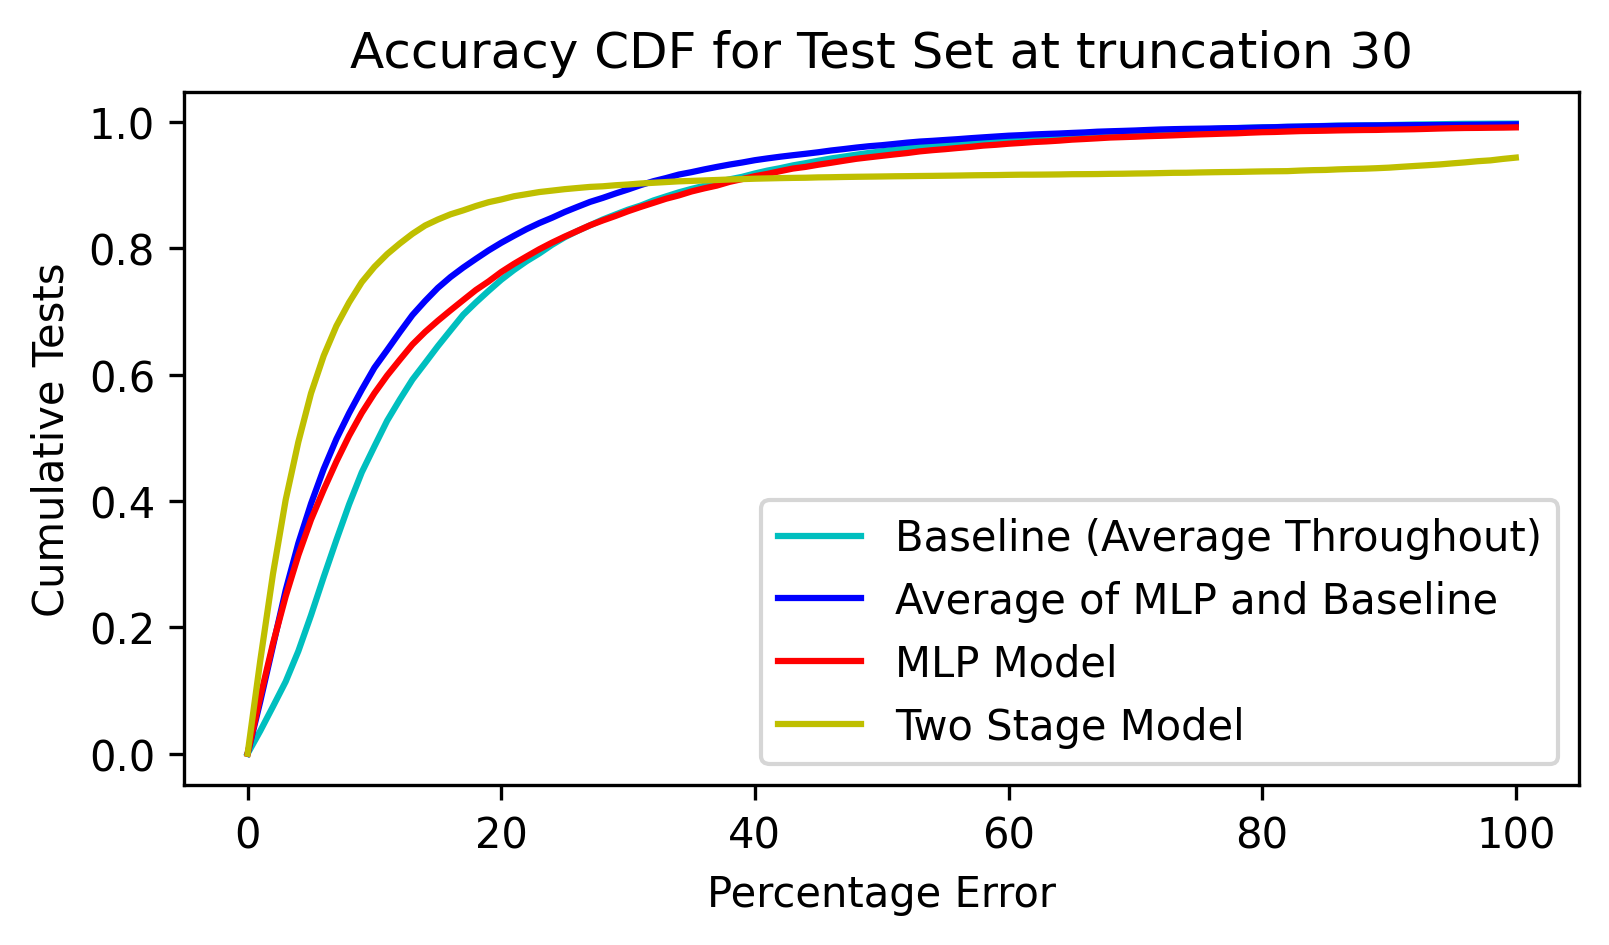

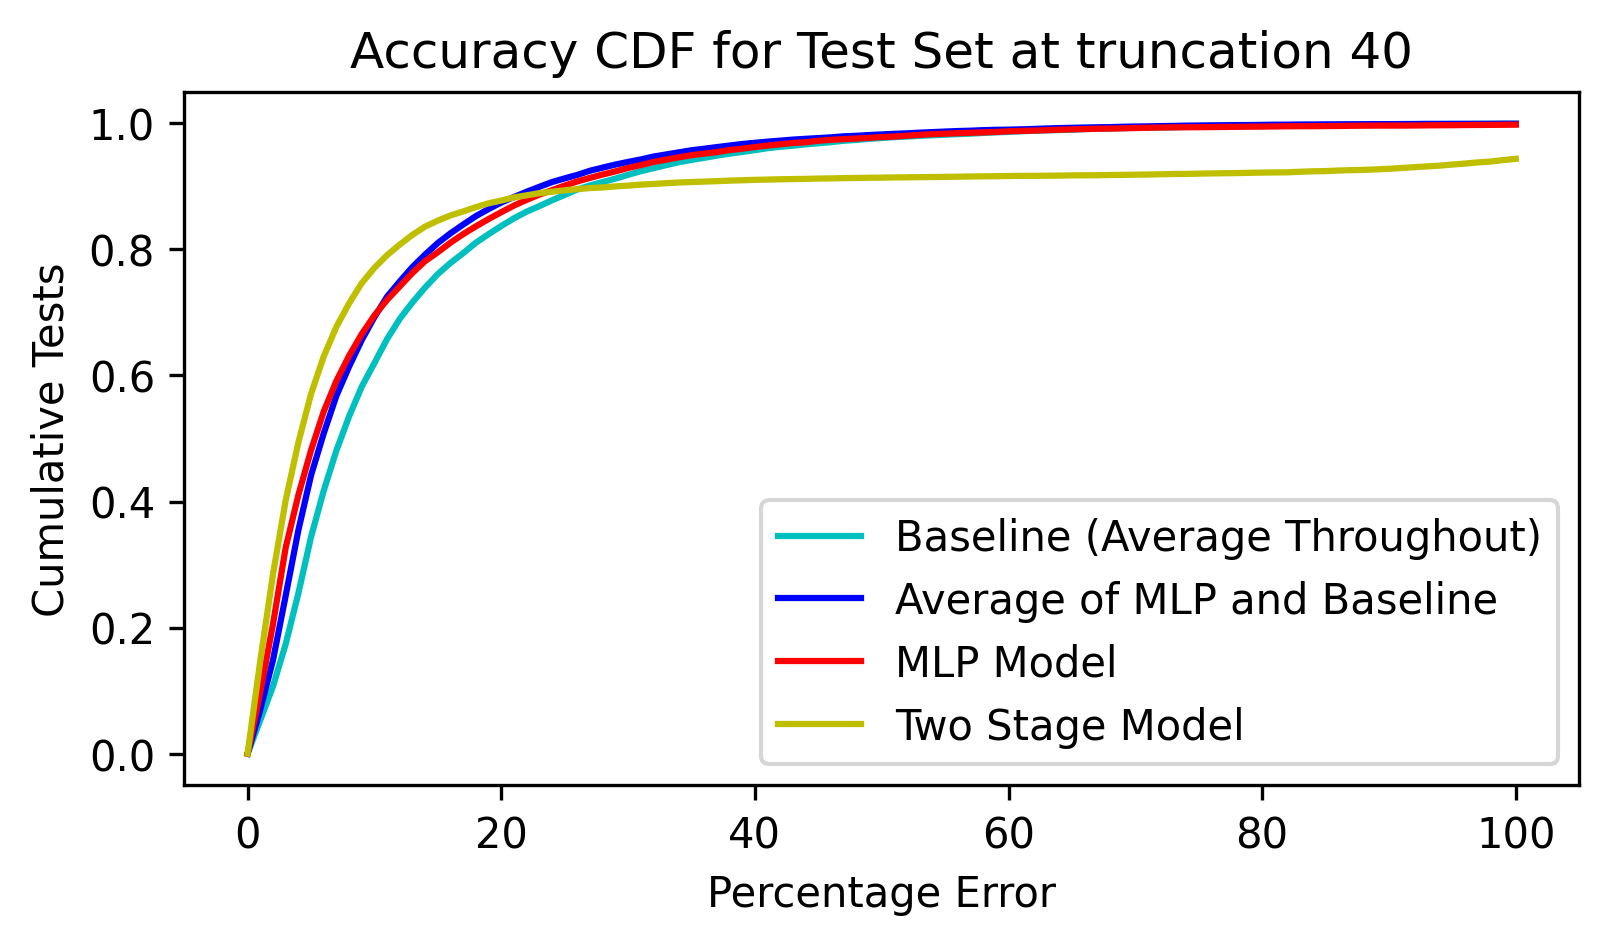

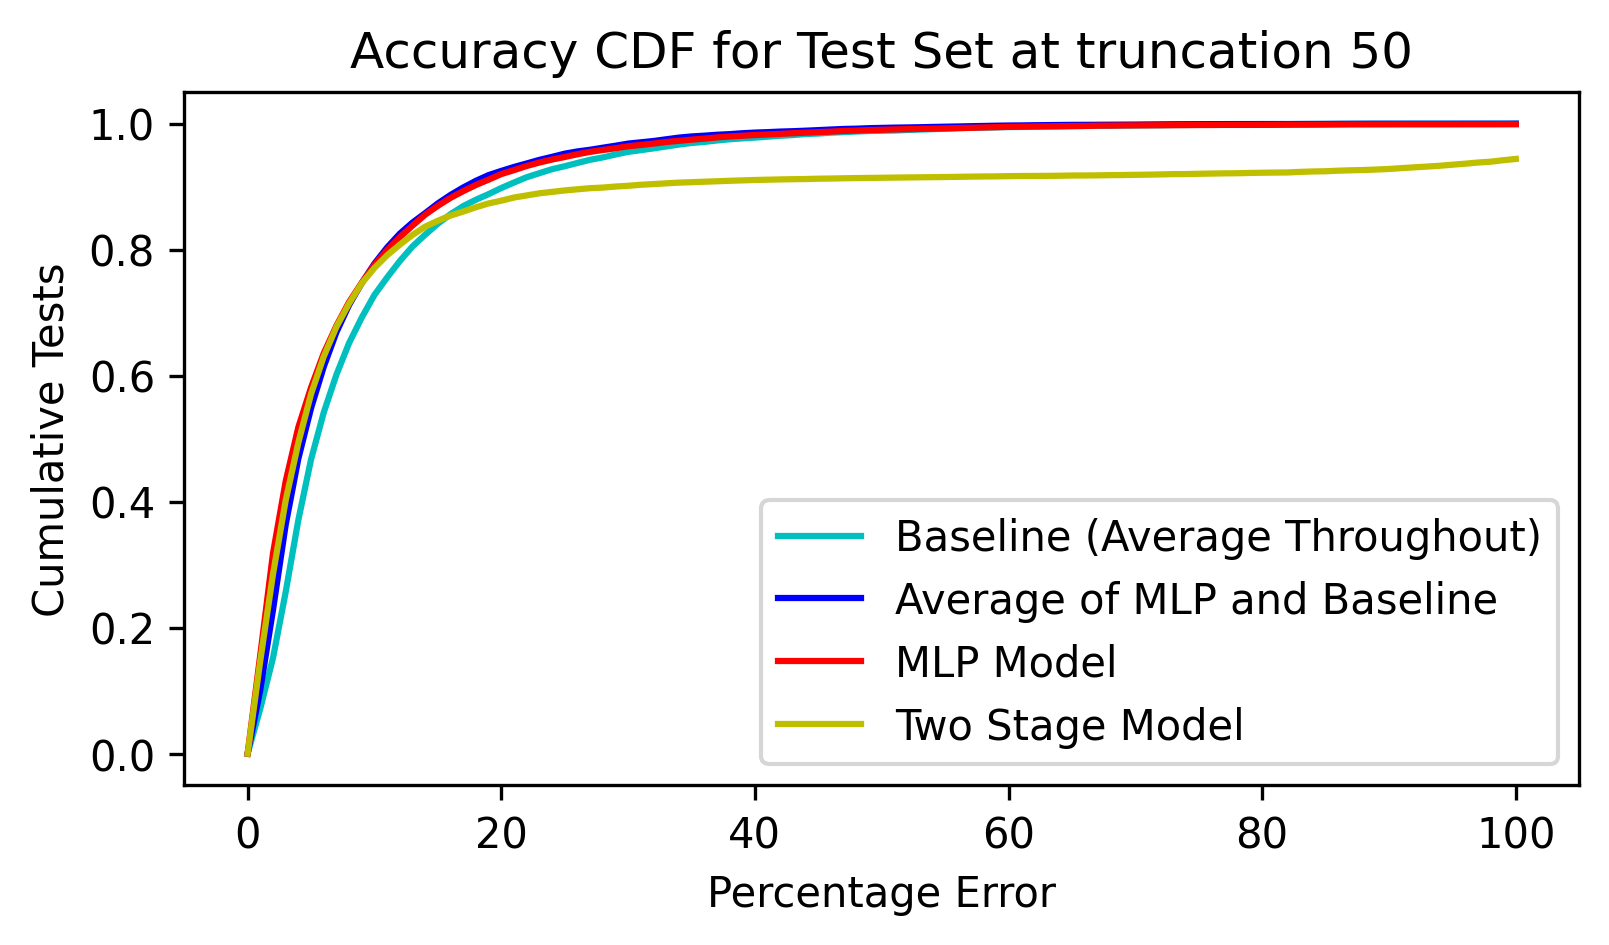

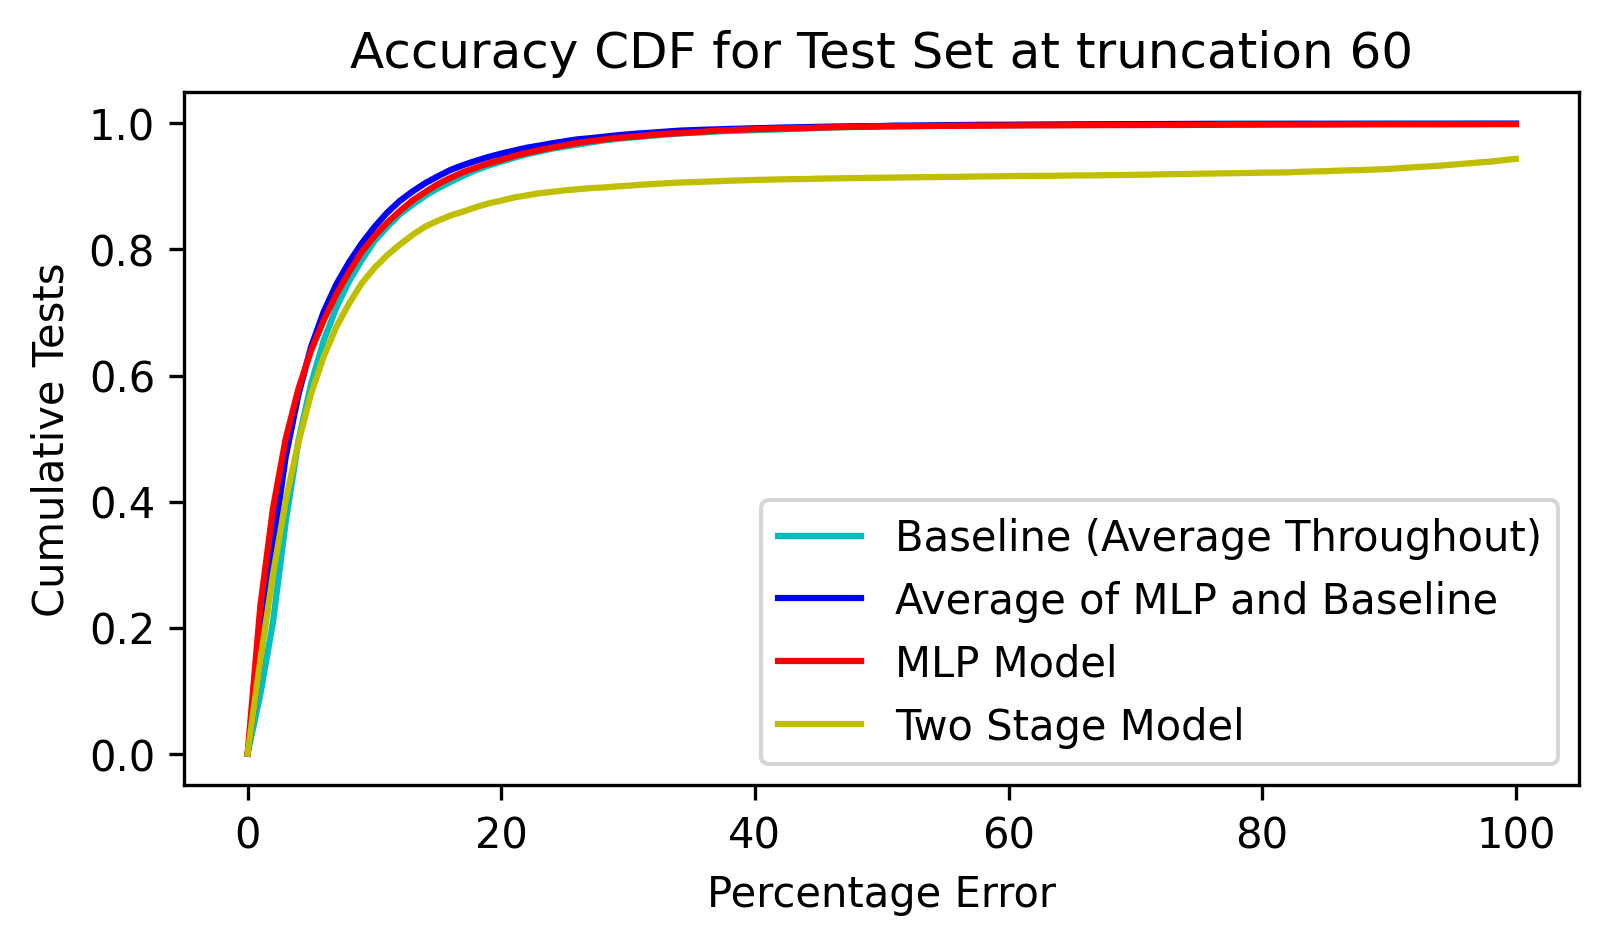

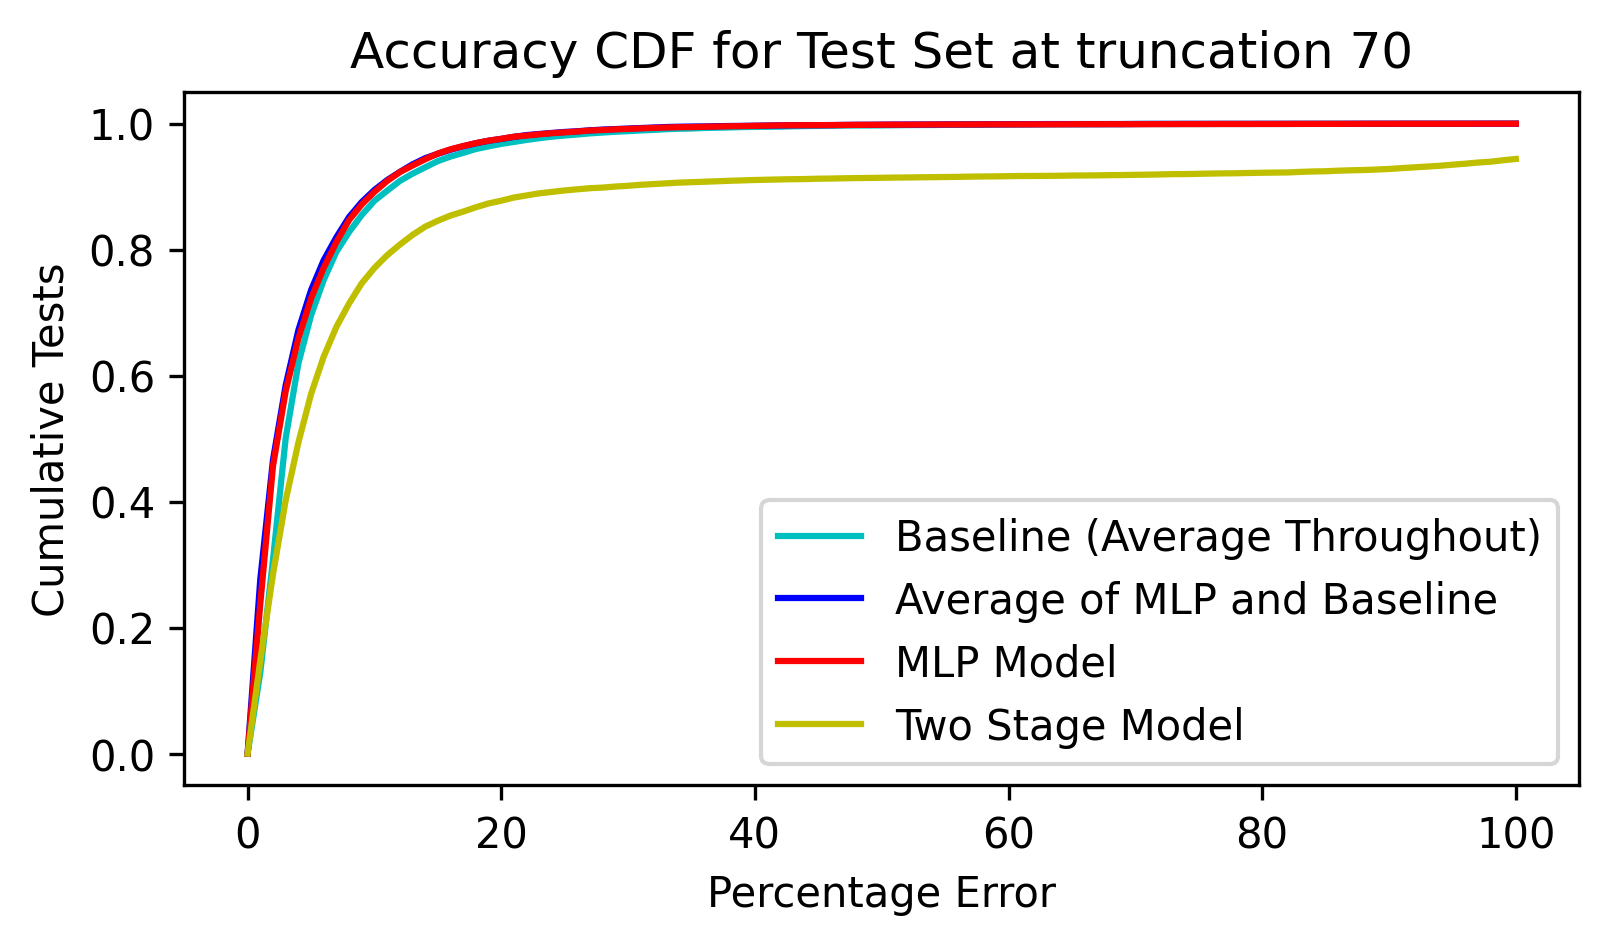

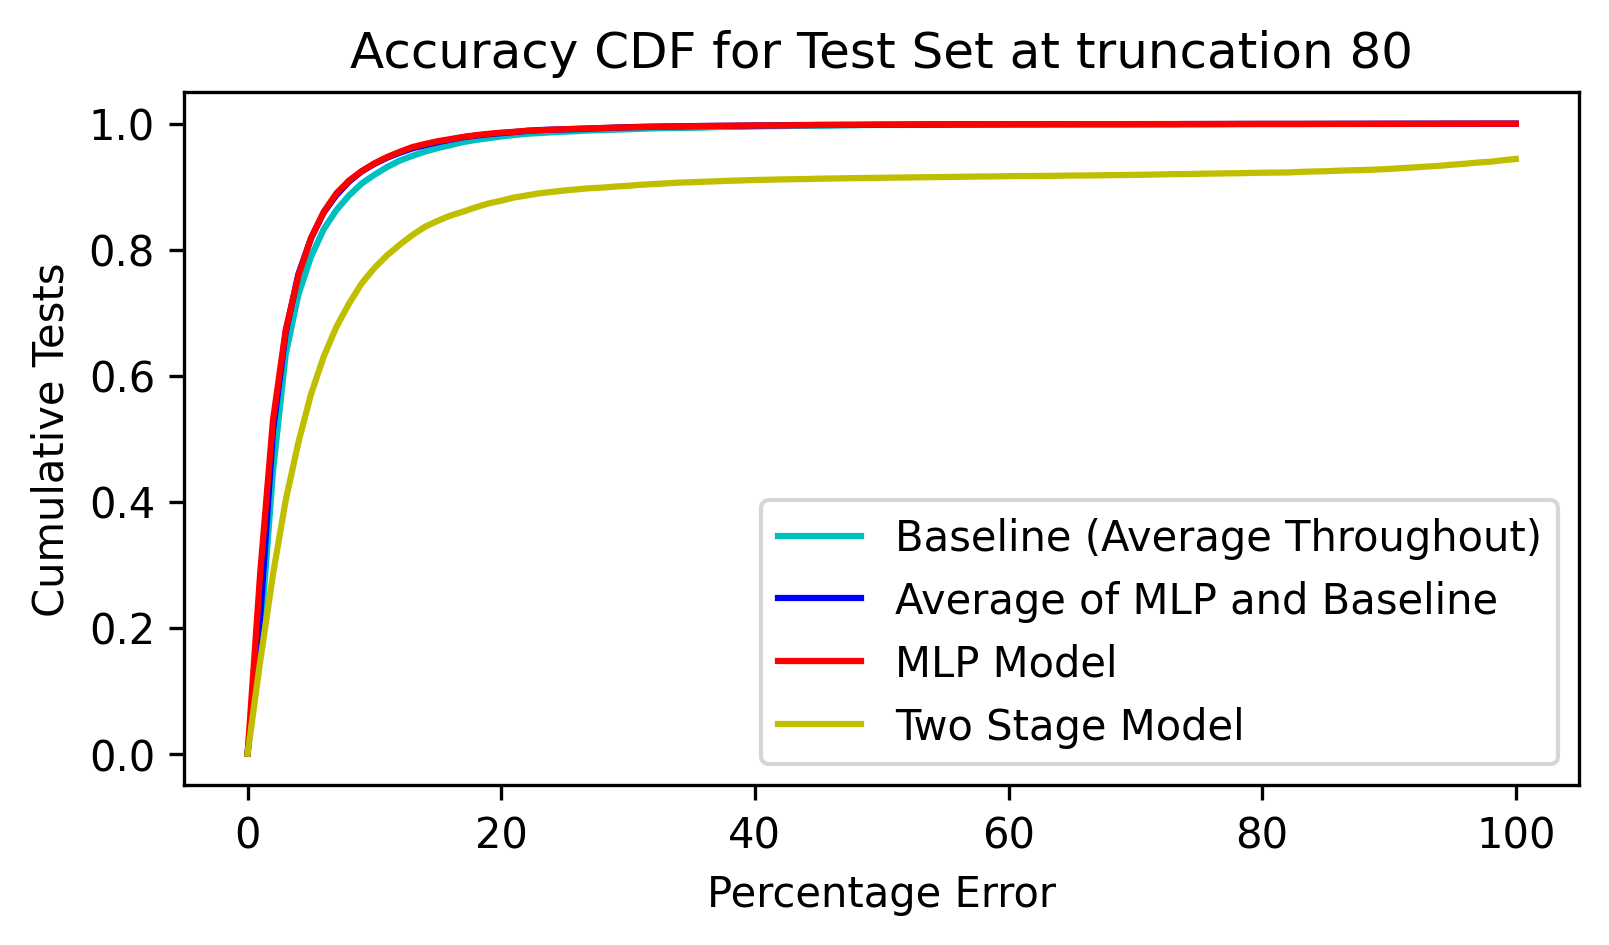

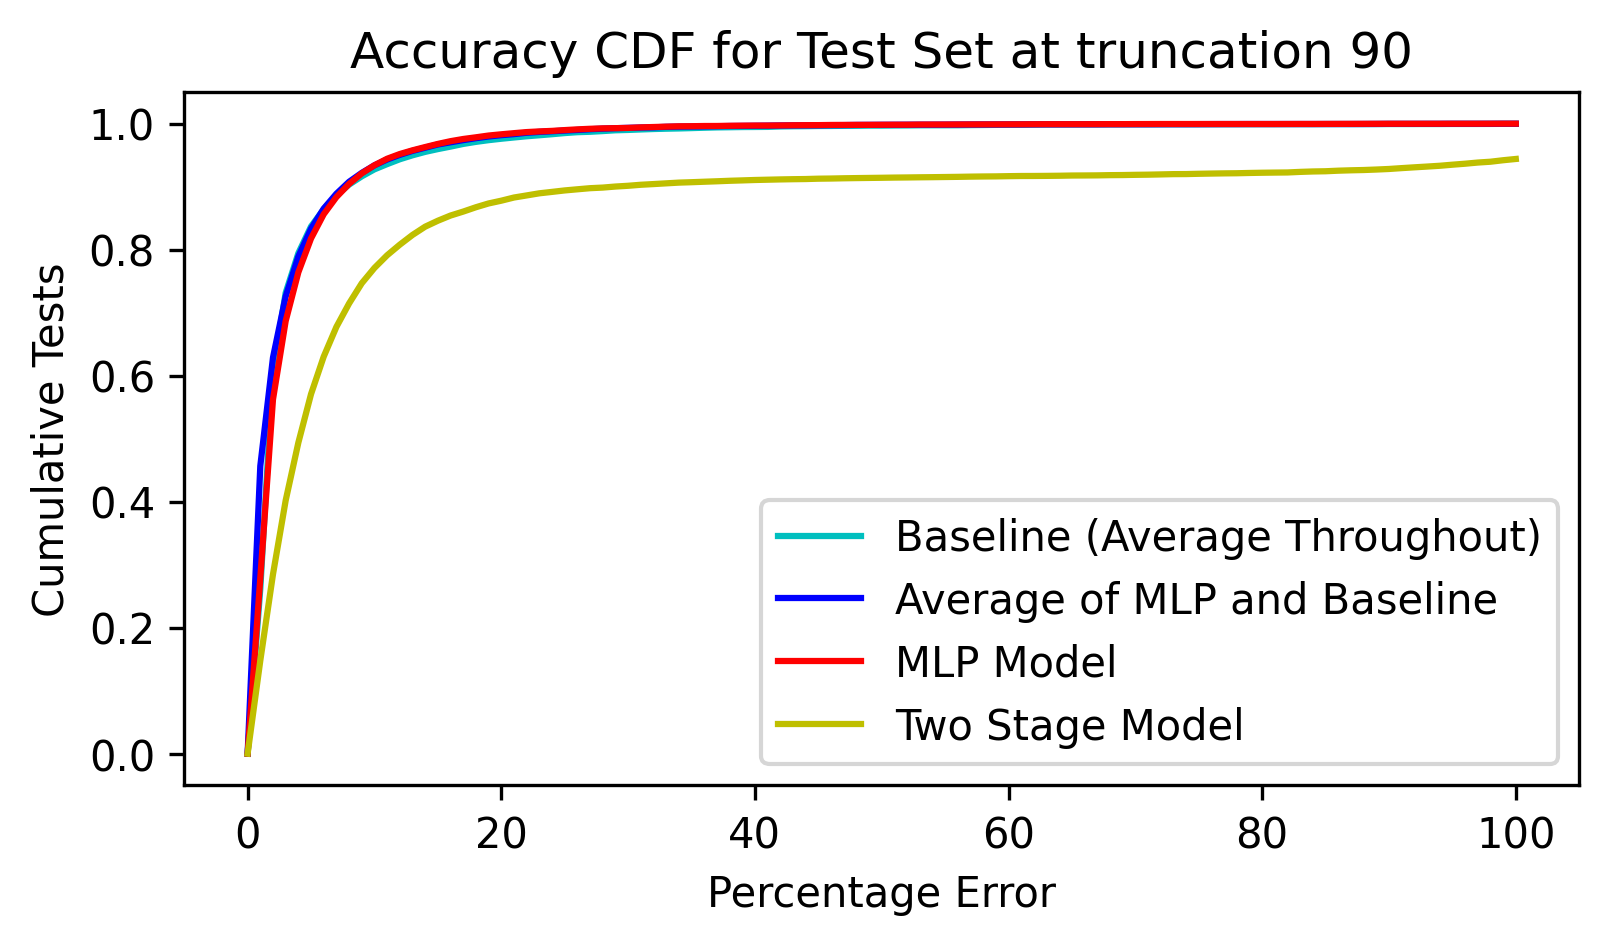

In [53]:
def get_frequencies_for_cdf(differences):
    """Returns a list of 100 percentile values.
    """
    freq = []
    for p in range(101):
        freq.append((differences < 0.01 * p).sum() / len(differences))
    return freq

two_stage_freq = get_frequencies_for_cdf(two_stage_model_diffs)

for truncateN in truncateNs:
  freq = get_frequencies_for_cdf(model_diffs[truncateN])
  print(f"Average error for {truncateN}:", round((sum(model_diffs[truncateN]) / len(model_diffs[truncateN]))*100, 1))
  baseline_freq = get_frequencies_for_cdf(baseline_diffs[truncateN])
  print(f"Average baseline error for {truncateN}:", round((sum(baseline_diffs[truncateN]) / len(baseline_diffs[truncateN]))*100, 1))
  average_freq = get_frequencies_for_cdf(average_diffs[truncateN])

  fig, ax = plt.subplots(dpi=300, figsize=(6, 3))

  ax.set_title(f"Accuracy CDF for Test Set at truncation {truncateN}")
  ax.set_xlabel("Percentage Error")
  ax.set_ylabel("Cumulative Tests")
  ax.plot(list(range(101)), baseline_freq, color='c', label=f"Baseline (Average Throughout)")
  ax.plot(list(range(101)), average_freq, color='b', label=f"Average of MLP and Baseline")
  ax.plot(list(range(101)), freq, color='r', label=f"MLP Model")
  ax.plot(list(range(101)), two_stage_freq, color='y', label=f"Two Stage Model")
  plt.legend()

### Visualizations for a particular truncation

In [ ]:
# Whether to enable printing the visualizations
plot_visualization = True
SNAPSHOT_TRUNC_FOR_VISUALIZATION = 50

#### Training Set

In [ ]:
if plot_visualization:
  plot_snapshots(
      valid_serieses_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      valid_returnedthroughputs_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      30, 10,
      predictedthroughputs=train_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      predictedvars=train_preds_var_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION])

#### Training Set with truncation

In [ ]:
if plot_visualization:
  plot_snapshots(
      valid_serieses_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      valid_returnedthroughputs_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      30, 10,
      truncate=SNAPSHOT_TRUNC_FOR_VISUALIZATION,
      predictedthroughputs=train_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      predictedvars=train_preds_var_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION])

#### Test set

In [ ]:
if plot_visualization:
  plot_snapshots(
      valid_serieses_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      valid_returnedthroughputs_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      100, 10,
      predictedthroughputs=test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      predictedvars=test_preds_var_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION])

#### Test set with truncation

In [ ]:
if plot_visualization:
  plot_snapshots(
      valid_serieses_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      valid_returnedthroughputs_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      30, 10,
      truncate=SNAPSHOT_TRUNC_FOR_VISUALIZATION,
      predictedthroughputs=test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      predictedvars=test_preds_var_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION])

#### Test set with truncation using Average of MLP and Baseline Predictions

In [ ]:
if plot_visualization:
  plot_snapshots(
      valid_serieses_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(averages[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      valid_returnedthroughputs_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(averages[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      30, 10,
      truncate=SNAPSHOT_TRUNC_FOR_VISUALIZATION,
      predictedthroughputs=averages[SNAPSHOT_TRUNC_FOR_VISUALIZATION])

### Error Analysis

#### Test Set

In [ ]:
SNAPSHOT_TRUNC_FOR_VISUALIZATION = 90

In [ ]:
if plot_visualization:
  plot_snapshots(
      valid_serieses_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      valid_returnedthroughputs_map[SNAPSHOT_TRUNC_FOR_VISUALIZATION][-len(test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION]):],
      3, 5,
      predictedthroughputs=test_preds_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      predictedvars=test_preds_var_unnorm[SNAPSHOT_TRUNC_FOR_VISUALIZATION],
      error_threshold=0.8,
  )